In [500]:
import pandas as pd
import os,sys, imp, glob
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import pos_yap_process
import feature_utils
import common_utils, model_utils
import defines
import numpy as np
import re
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,plot_confusion_matrix
import matplotlib.pyplot as plt


In [438]:
doc_list =  glob.glob(os.path.join(os.path.join(os.getcwd(),"tmp","agreement",r"*_Compare_*.docx")))
doc_list.sort()
doc_map = {}

for idx,doc in enumerate(doc_list):
    f_name=re.sub('.docx','',os.path.basename(doc).split('_')[-1])
    doc_map[f_name] = doc
doc_map

{'Dana': '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/tmp/agreement/01_Compare_Dana.docx',
 'Mor': '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/tmp/agreement/02_Compare_Mor.docx'}

In [439]:
dir_name="agreement"

In [440]:
doc_db=pd.read_csv(os.path.join(os.getcwd(), defines.PATH_TO_DFS, dir_name, "doc_db.csv"))
doc_db

,path,file_name,doc_idx_from_name
0,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,01_Compare_Dana.docx,1
1,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,02_Compare_Mor.docx,2


In [441]:
dir_name

'agreement'

In [442]:
imp.reload(doc_utils)
doc_utils.parse_all_docs(dir_name=dir_name,merge_short_sent=False,doc_path_list=doc_list)

Creating doc_db
738 sentences 0 738 sentences 1 

In [443]:
db = {}
for db_type in ['par_db','sent_db','block_db']:
    db[db_type]={}
    for idx in doc_db['doc_idx_from_name'].values:
        db[db_type][idx]=pd.read_csv(os.path.join(os.getcwd(), defines.PATH_TO_DFS, dir_name, "{:02d}_{}.csv".format(idx,db_type)))

In [444]:
for key,value in db.items():
    print(key,len(value[1]),len(value[2]))


par_db 164 164
sent_db 738 738
block_db 212 200


In [541]:
dana_nar =  db['sent_db'][1].groupby('nar_idx').size()
dana_nar

nar_idx
0.000000     481
1.000000       5
2.000000       5
3.000000      13
4.000000       2
5.000000       4
6.000000       4
7.000000       4
8.000000       8
9.000000       4
10.000000     11
11.000000      8
12.000000     93
13.000000     13
14.000000      8
15.000000      6
16.000000      5
17.000000     10
18.000000      5
19.000000     16
20.000000     14
21.000000      2
22.000000     11
23.000000      4
24.000000      2
dtype: int64

In [542]:
mor_nar =  db['sent_db'][2].groupby('nar_idx').size()
mor_nar

nar_idx
0.000000     485
1.000000       5
2.000000       2
3.000000       5
4.000000       4
5.000000       8
6.000000       5
7.000000      12
8.000000      22
9.000000      21
10.000000     78
11.000000     13
12.000000     14
13.000000     15
14.000000     15
15.000000     18
16.000000      4
17.000000      8
18.000000      4
dtype: int64

In [535]:
db['sent_db'][2]['nar_idx'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18.])

In [445]:
sent_count={}
sent_count[1]=db['sent_db'][1].groupby('par_idx_in_doc').size()

In [446]:
sent_count[2]=db['sent_db'][2].groupby('par_idx_in_doc').size()

In [447]:
sent_count[2]

par_idx_in_doc
0.000000      1
1.000000      1
2.000000      2
3.000000      1
4.000000      1
             ..
159.000000    1
160.000000    2
161.000000    1
162.000000    5
163.000000    8
Length: 160, dtype: int64

In [448]:
db_diff = pd.DataFrame()
db_diff['1']=sent_count[1]
db_diff['2']=sent_count[2]
db_diff

,1,2
par_idx_in_doc,,
0.000000,1,1
1.000000,1,1
2.000000,2,2
3.000000,1,1
4.000000,1,1
...,...,...
159.000000,1,1
160.000000,2,2
161.000000,1,1


In [449]:
db_diff[db_diff['1']!=db_diff['2']]

,1,2
par_idx_in_doc,,


In [450]:
diff_par_indices=db_diff[db_diff['1']!=db_diff['2']].index

In [481]:
db['block_db'][2].query("par_db_idx == 49")

,text,is_nar,doc_idx,par_idx_in_doc,par_pos_in_doc,par_db_idx,par_type,block_type,nar_idx
62,"\tואז, שאלתי את עצמי אחרי זה, הוא אמר, זה יפה ...",1.000000,2.000000,49.000000,0.304878,49.000000,client,end,7.000000
63,". ועכשיו, מה שקורה זה שדברים באים לי מאוד בקל...",0.000000,2.000000,49.000000,0.304878,49.000000,client,not_nar,0.000000
64,"&פתאום סיפרתי לך על הבחור הזה שהכרתי, שאני לא ...",1.000000,2.000000,49.000000,0.304878,49.000000,client,start,8.000000


In [451]:
with pd.option_context('display.max_colwidth', None):
    display(db['block_db'][1].query("par_db_idx.isin(@diff_par_indices)")[['text','par_db_idx','par_type','is_nar']])

,text,par_db_idx,par_type,is_nar


In [452]:
with pd.option_context('display.max_colwidth', None):
    display(db['block_db'][2].query("par_db_idx.isin(@diff_par_indices)")[['text','par_db_idx','par_type','is_nar']])

,text,par_db_idx,par_type,is_nar


In [453]:
for idx in diff_par_indices:
    with pd.option_context('display.max_colwidth', None):
        display(db['sent_db'][1].query("par_idx_in_doc == @idx")[['text','sent_idx_in_par','par_type','is_nar','par_idx_in_doc']])

In [454]:
for idx in diff_par_indices:
    with pd.option_context('display.max_colwidth', None):
        display(db['sent_db'][2].query("par_idx_in_doc == @idx")[['text','sent_idx_in_par','par_type','is_nar','par_idx_in_doc']])

In [ ]:
for idx in diff_par_indices:
    with pd.option_context('display.max_colwidth', None):
        display(db['sent_db'][1].query("par_idx_in_doc == @idx")[['text','sent_idx_in_par','par_type','is_nar','par_idx_in_doc']])

In [456]:
dana_label=db['sent_db'][1]['is_nar'].tolist()
mor_label=db['sent_db'][2]['is_nar'].tolist()


              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       481
         1.0       0.88      0.87      0.87       257

    accuracy                           0.91       738
   macro avg       0.91      0.90      0.90       738
weighted avg       0.91      0.91      0.91       738



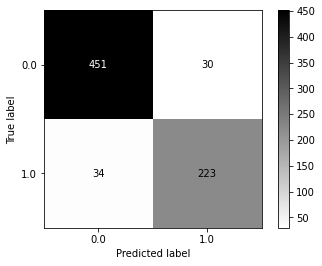

In [458]:
feature_utils.get_prediction_report(dana_label,mor_label,np.unique(dana_label))

Text(0, 0.5, 'Dana')

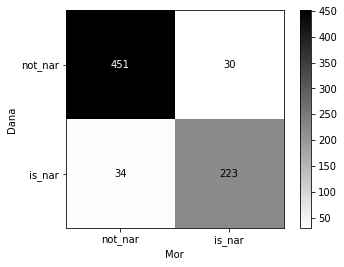

In [525]:
cm = confusion_matrix(dana_label, mor_label, labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['not_nar','is_nar'])
fig, ax = plt.subplots()
  
ax.grid(False)
 
disp.plot(ax=ax,cmap='gray_r')
ax.set_xlabel('Mor')
ax.set_ylabel('Dana')

In [526]:
img_path =os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"agreement_matrix.png")
fig.savefig(img_path)

## Calculate Kappa score

In [601]:
from sklearn.metrics import cohen_kappa_score
agr_score=cohen_kappa_score(dana_label, mor_label)
agr_score

0.8082634429117717

In [604]:
dir_name

'agreement'

In [607]:
imp.reload(common_utils)
common_utils.save_json(agr_score,dir_name,'kappa_val')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/agreement/kappa_val.json


### Build pred info DF to see differences

In [527]:
pred_info_df = db['sent_db'][1][['text','par_idx_in_doc','is_nar','nar_idx']].copy()

In [597]:
pred_info_df['label']=pred_info_df['is_nar']
pred_info_df

,text,par_idx_in_doc,is_nar,nar_idx,label,pred,doc_idx
0,היי,0.000000,0.000000,0.000000,0.000000,not_nar,5
1,היי,1.000000,0.000000,0.000000,0.000000,not_nar,5
2,להכנס או להשאר בחוץ ותקראי לי,2.000000,0.000000,0.000000,0.000000,not_nar,5
3,כאילו,2.000000,0.000000,0.000000,0.000000,not_nar,5
4,אה,3.000000,0.000000,0.000000,0.000000,not_nar,5
...,...,...,...,...,...,...,...
733,מה מה עכשיו הבחירות כשהאנרגיה חזרה,163.000000,0.000000,0.000000,0.000000,not_nar,5
734,מה עכשיו אתה עושה עם הדברים ו כל השאלות האלה ש...,163.000000,0.000000,0.000000,0.000000,not_nar,5
735,כשאני שומעת שהמשאלה היא לעשות משהו אחר,163.000000,0.000000,0.000000,0.000000,not_nar,5
736,כאילו ללכת יותר אתה קורא לזה עם ההנאה,163.000000,0.000000,0.000000,0.000000,not_nar,5


In [529]:
pred_info_df['pred']=db['sent_db'][2]['is_nar']
pred_info_df

,text,par_idx_in_doc,is_nar,nar_idx,label,pred
0,היי,0.000000,0.000000,0.000000,0.000000,0.000000
1,היי,1.000000,0.000000,0.000000,0.000000,0.000000
2,להכנס או להשאר בחוץ ותקראי לי,2.000000,0.000000,0.000000,0.000000,0.000000
3,כאילו,2.000000,0.000000,0.000000,0.000000,0.000000
4,אה,3.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
733,מה מה עכשיו הבחירות כשהאנרגיה חזרה,163.000000,0.000000,0.000000,0.000000,0.000000
734,מה עכשיו אתה עושה עם הדברים ו כל השאלות האלה ש...,163.000000,0.000000,0.000000,0.000000,0.000000
735,כשאני שומעת שהמשאלה היא לעשות משהו אחר,163.000000,0.000000,0.000000,0.000000,0.000000
736,כאילו ללכת יותר אתה קורא לזה עם ההנאה,163.000000,0.000000,0.000000,0.000000,0.000000


In [530]:
pred_info_df['doc_idx']=5
pred_info_df

,text,par_idx_in_doc,is_nar,nar_idx,label,pred,doc_idx
0,היי,0.000000,0.000000,0.000000,0.000000,0.000000,5
1,היי,1.000000,0.000000,0.000000,0.000000,0.000000,5
2,להכנס או להשאר בחוץ ותקראי לי,2.000000,0.000000,0.000000,0.000000,0.000000,5
3,כאילו,2.000000,0.000000,0.000000,0.000000,0.000000,5
4,אה,3.000000,0.000000,0.000000,0.000000,0.000000,5
...,...,...,...,...,...,...,...
733,מה מה עכשיו הבחירות כשהאנרגיה חזרה,163.000000,0.000000,0.000000,0.000000,0.000000,5
734,מה עכשיו אתה עושה עם הדברים ו כל השאלות האלה ש...,163.000000,0.000000,0.000000,0.000000,0.000000,5
735,כשאני שומעת שהמשאלה היא לעשות משהו אחר,163.000000,0.000000,0.000000,0.000000,0.000000,5
736,כאילו ללכת יותר אתה קורא לזה עם ההנאה,163.000000,0.000000,0.000000,0.000000,0.000000,5


In [531]:
pred_info_df.replace({'label': {0:'not_nar',1:'is_nar'},
                     'pred': {0:'not_nar',1:'is_nar'}}, inplace=True)

In [532]:
pred_info_df

,text,par_idx_in_doc,is_nar,nar_idx,label,pred,doc_idx
0,היי,0.000000,0.000000,0.000000,not_nar,not_nar,5
1,היי,1.000000,0.000000,0.000000,not_nar,not_nar,5
2,להכנס או להשאר בחוץ ותקראי לי,2.000000,0.000000,0.000000,not_nar,not_nar,5
3,כאילו,2.000000,0.000000,0.000000,not_nar,not_nar,5
4,אה,3.000000,0.000000,0.000000,not_nar,not_nar,5
...,...,...,...,...,...,...,...
733,מה מה עכשיו הבחירות כשהאנרגיה חזרה,163.000000,0.000000,0.000000,not_nar,not_nar,5
734,מה עכשיו אתה עושה עם הדברים ו כל השאלות האלה ש...,163.000000,0.000000,0.000000,not_nar,not_nar,5
735,כשאני שומעת שהמשאלה היא לעשות משהו אחר,163.000000,0.000000,0.000000,not_nar,not_nar,5
736,כאילו ללכת יותר אתה קורא לזה עם ההנאה,163.000000,0.000000,0.000000,not_nar,not_nar,5


In [557]:
comp_db=pd.DataFrame()
for idx in pred_info_df.index:
    row=pred_info_df.iloc[idx,:]
    if row['label'] == 'is_nar' or  row['pred']== 'is_nar':
        curr_idx=comp_db.shape[0]
        comp_db.loc[curr_idx,'text']=row['text']
        comp_db.loc[curr_idx,'sent_idx']=idx
        comp_db.loc[curr_idx,'Dana'] = 1 if row['label'] == 'is_nar' else 0
        comp_db.loc[curr_idx,'Mor'] = 1 if row['pred'] == 'is_nar' else 0
        comp_db.loc[curr_idx,'Dana_idx'] = db['sent_db'][1].loc[idx,'nar_idx']
        comp_db.loc[curr_idx,'Mor_idx'] = db['sent_db'][2].loc[idx,'nar_idx']
comp_db

,text,sent_idx,Dana,Mor,Dana_idx,Mor_idx
0,שיער,34.000000,1.000000,1.000000,1.000000,1.000000
1,יש לי תסביך שיער מגיל 15 בערך,35.000000,1.000000,1.000000,1.000000,1.000000
2,כן מה,36.000000,1.000000,1.000000,1.000000,1.000000
3,בגיל 13 14 הייתי מגיל 14 התחלתי לשים גל בשיער ...,37.000000,1.000000,1.000000,1.000000,1.000000
4,ממש קוץ קוץ הייתי מסדר אחד אחד,38.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...
282,והחלטתי שזה זה לא לא לא הרגיש לי נכון לעשות את זה,675.000000,1.000000,1.000000,23.000000,18.000000
283,את השינוי הזה,676.000000,1.000000,1.000000,23.000000,18.000000
284,אבל לא יודע אם בא לי עכשיו את כל ה שם הזה עם ה,677.000000,1.000000,1.000000,23.000000,18.000000
285,הוא אמר לי – אם אתה היית במקומי אתה היית הולך,700.000000,1.000000,0.000000,24.000000,0.000000


In [596]:
comp_db.query("Dana_idx!=0").count()

text             257
sent_idx         257
Dana             257
Mor              257
Dana_idx         257
Mor_idx          257
Dana_nar_size     25
Dana_nar_len     257
Mor_nar_len      257
dtype: int64

In [ ]:
comp_db['Dana_nar_len'] = comp_db.groupby('Dana_idx')['sent_idx'].transform(len)
comp_db

In [576]:
comp_db['Mor_nar_len'] = comp_db.groupby('Mor_idx')['sent_idx'].transform(len)
comp_db

,text,sent_idx,Dana,Mor,Dana_idx,Mor_idx,Dana_nar_size,Dana_nar_len,Mor_nar_len
0,שיער,34.000000,1.000000,1.000000,1.000000,1.000000,30.000000,5,5
1,יש לי תסביך שיער מגיל 15 בערך,35.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5,5
2,כן מה,36.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5,5
3,בגיל 13 14 הייתי מגיל 14 התחלתי לשים גל בשיער ...,37.000000,1.000000,1.000000,1.000000,1.000000,13.000000,5,5
4,ממש קוץ קוץ הייתי מסדר אחד אחד,38.000000,1.000000,1.000000,1.000000,1.000000,2.000000,5,5
...,...,...,...,...,...,...,...,...,...
282,והחלטתי שזה זה לא לא לא הרגיש לי נכון לעשות את זה,675.000000,1.000000,1.000000,23.000000,18.000000,NaN,4,4
283,את השינוי הזה,676.000000,1.000000,1.000000,23.000000,18.000000,NaN,4,4
284,אבל לא יודע אם בא לי עכשיו את כל ה שם הזה עם ה,677.000000,1.000000,1.000000,23.000000,18.000000,NaN,4,4
285,הוא אמר לי – אם אתה היית במקומי אתה היית הולך,700.000000,1.000000,0.000000,24.000000,0.000000,NaN,2,34


In [591]:
len(comp_db['Dana_idx'].unique()),len(comp_db['Mor_idx'].unique())

(25, 19)

In [584]:
same_idx=comp_db.query("Dana_idx!=0 and Mor_idx!=0 and Dana_nar_len==Mor_nar_len").index

In [590]:
len(comp_db.iloc[same_idx,:]['Dana_idx'].unique())

6

In [589]:
comp_db.iloc[comp_db.index.difference(same_idx),:]['Dana_idx'].unique()

array([ 2.,  3.,  0.,  5.,  6.,  8.,  9., 10., 11., 12., 14., 15., 16.,
       17., 18., 19., 20., 21., 22., 24.])

In [558]:
comp_db[comp_db['Dana']!=comp_db['Mor']]

,text,sent_idx,Dana,Mor,Dana_idx,Mor_idx
5,עשיתי על זה כבר עבודה על זה עם הפסיכולוגית הקו...,44.000000,1.000000,0.000000,2.000000,0.000000
6,הרבה,45.000000,1.000000,0.000000,2.000000,0.000000
7,אבל אה אפרופו תדמיות,46.000000,1.000000,0.000000,2.000000,0.000000
8,זה בכל אופן אני לא רוצה זה לא ה מה שהייתי רוצ...,47.000000,1.000000,0.000000,2.000000,0.000000
9,כאילו מרגיש לי מטופל הנושא הזה,48.000000,1.000000,0.000000,2.000000,0.000000
...,...,...,...,...,...,...
270,ואנשים כאילו יש כאלה שיודעים,629.000000,1.000000,0.000000,22.000000,0.000000
271,יודעים,630.000000,1.000000,0.000000,22.000000,0.000000
272,יש כאלה ש לא יודעים אבל מנחשים או אוספים את ההקשר,631.000000,1.000000,0.000000,22.000000,0.000000
285,הוא אמר לי – אם אתה היית במקומי אתה היית הולך,700.000000,1.000000,0.000000,24.000000,0.000000


In [523]:
dir_name

'agreement'

In [524]:
imp.reload(model_utils)
strong_err_idx=pred_info_df.index
model_utils.print_error_par_text(dir_name,strong_err_idx,pred_info_df,0)